# Noise and Error Mitigitation in Quantum Real Circuits 
## Basado en el siguiente tutorial:
https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/Coding_With_Qiskit/ep8_Noise_and_Error_Mitigation.ipynb

In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor

In [3]:
from qiskit import *

In [4]:
# Descomente la siguiente linea si desea ver las imágenes más grandes.
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

In [5]:
nqubits = 3
circuit = QuantumCircuit(nqubits, nqubits)
circuit.h(0)
circuit.cx(0,1)
circuit.cx(1,2)
circuit.measure([0,1,2], [0,1,2])

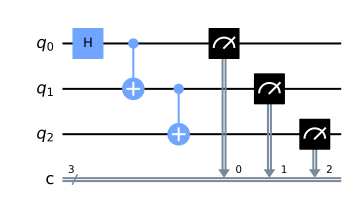

In [6]:
circuit.draw(output='mpl')

In [7]:
simulator = Aer.get_backend('qasm_simulator')
sim_result = execute(circuit, backend=simulator, shots=1024).result()

In [8]:
from qiskit.visualization import plot_histogram

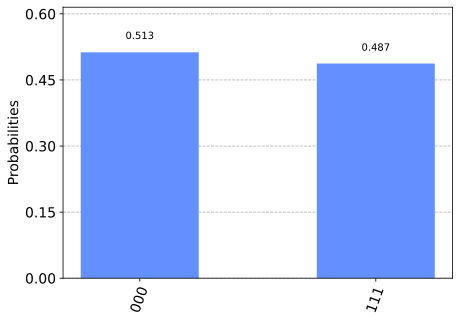

In [9]:
plot_histogram(sim_result.get_counts(circuit))

In [10]:
#IBMQ.load_account()
#provider = IBMQ.get_provider(hub='ibm-q')
#device = provider.get_backend('ibmqx2')

In [11]:
# First, see what devices we are allowed to use by loading our saved accounts
IBMQ.load_account()
#provider = IBMQ.get_provider(hub='ibm-q')
provider = IBMQ.get_provider(hub='ibm-q-education', group='uni-antioquia-1', project='qc2021')
#Remote_QProcessor = provider.get_backend('ibm_perth')
#Remote_QSimulator = provider.get_backend('ibmq_qasm_simulator')

In [12]:
#Remote_QProcessor = provider.get_backend('ibm_lagos') Maquina reservada temporalmente

In [13]:
#Remote_QProcessor = least_busy(provider.backends(filters=lambda qprocessor: qprocessor.configuration().n_qubits >= 2 
#                                       and not qprocessor.configuration().simulator 
#                                       and qprocessor.status().operational==True))
#print("El computador cuántico menos ocupado es el " + Remote_QProcessor.name())

In [14]:
Remote_QProcessor=provider.get_backend('ibm_oslo')

In [15]:
#job = execute(circuit, backend=Remote_QProcessor, shots=1024)
#job = execute(circuit, backend=Remote_QSimulator, shots=1024)
#print(job.job_id())
#job_monitor(job)

In [16]:
job2=Remote_QProcessor.jobs()[0]

In [17]:
job2.status()

<JobStatus.DONE: 'job has successfully run'>

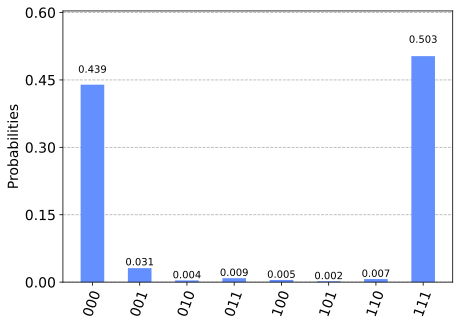

In [18]:
device_result = job2.result()
plot_histogram(device_result.get_counts(circuit))

In [ ]:
# Definition of Calibration Circuits to mitigate the measurement error.

In [19]:
#from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from qiskit.utils.mitigation import (complete_meas_cal, tensored_meas_cal,
                                        CompleteMeasFitter, TensoredMeasFitter)

In [20]:
calibration_circuits, quantum_states = complete_meas_cal(qr=circuit.qregs[0], 
                                               circlabel='measurement_calibration')

In [21]:
quantum_states

['000', '001', '010', '011', '100', '101', '110', '111']

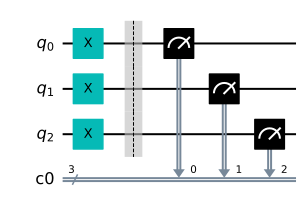

In [22]:
calibration_circuits[7].draw(output='mpl')

In [23]:
len(calibration_circuits)

8

In [24]:
cal_job = execute(calibration_circuits,
             backend=Remote_QProcessor,
             shots=8192,
             optimization_level=0)
print(cal_job.job_id())
#job_monitor(cal_job)
calibration_results = cal_job.result()

6332e332e150f12c839e2010


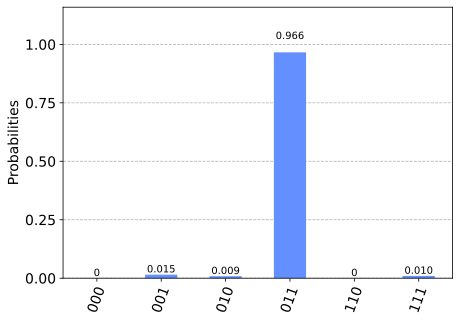

In [25]:
plot_histogram(calibration_results.get_counts(calibration_circuits[3]))

In [26]:
My_fitter = CompleteMeasFitter(calibration_results, quantum_states)

In [27]:
from qiskit.visualization import array_to_latex
array_to_latex(My_fitter.cal_matrix)

<IPython.core.display.Latex object>

In [ ]:
#My_fitter.plot_calibration()

In [28]:
Measurement_Filter = My_fitter.filter

# Mitigating the measurement errors in our previous device run

In [29]:
mitigated_result = Measurement_Filter.apply(device_result)

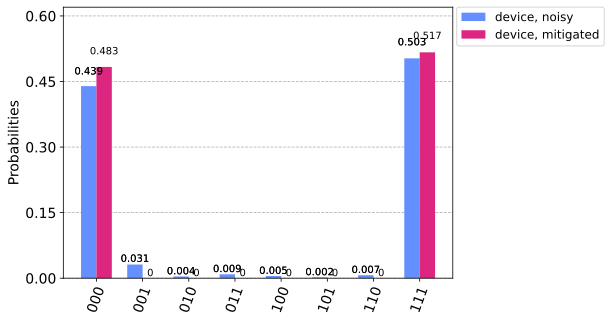

In [30]:
device_counts = device_result.get_counts(circuit)
mitigated_counts = mitigated_result.get_counts(circuit)
plot_histogram([device_counts, mitigated_counts], 
               legend=['device, noisy', 'device, mitigated'])

# Running error mitigation on a second circuit

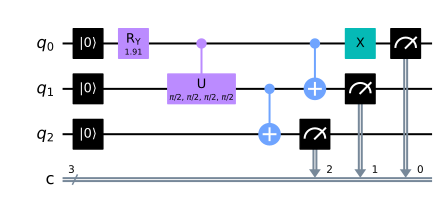

In [32]:
from ibm_quantum_widgets import CircuitComposer
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from numpy import pi

qreg_q = QuantumRegister(3, 'q')
creg_c = ClassicalRegister(3, 'c')
circuit3 = QuantumCircuit(qreg_q, creg_c)

circuit3.reset(qreg_q[0])
circuit3.reset(qreg_q[1])
circuit3.reset(qreg_q[2])
circuit3.ry(1.9106332362490184, qreg_q[0])
circuit3.cu(pi / 2, pi / 2, pi / 2, pi / 2, qreg_q[0], qreg_q[1])
circuit3.cx(qreg_q[1], qreg_q[2])
circuit3.cx(qreg_q[0], qreg_q[1])
circuit3.x(qreg_q[0])
circuit3.measure(qreg_q[0], creg_c[0])
circuit3.measure(qreg_q[1], creg_c[1])
circuit3.measure(qreg_q[2], creg_c[2])

circuit3.draw(output='mpl')

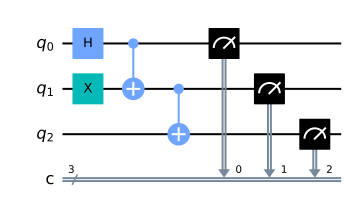

In [31]:
#circuit2 = QuantumCircuit(3,3)
#circuit2.x(1)
#circuit2.h(0)
#circuit2.cx(0,1)
#circuit2.cx(1,2)
#circuit2.measure([0,1,2], [0,1,2])
#circuit2.draw(output='mpl')

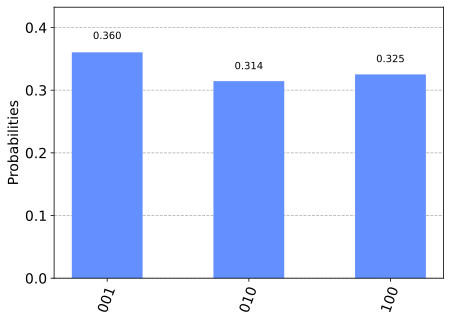

In [33]:
# Simulating the circuit and plotting the corresponding histogram:
Simulation_counts_2 = execute(circuit3, backend=simulator, shots=1024).result().get_counts(circuit3)
plot_histogram(Simulation_counts_2)

In [34]:
# Executing the circuit and plotting the corresponding histogram:
job2 = execute(circuit3, backend=Remote_QProcessor, shots=1024)
print(job2.job_id())
#job_monitor(job2)

6332e50c99f9df6fe6132bc4


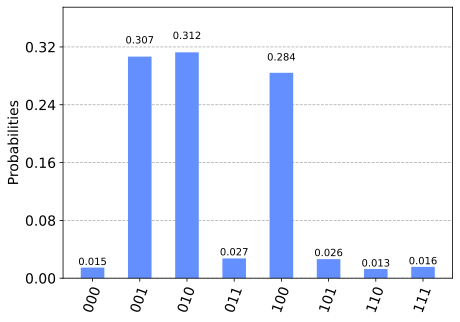

In [35]:
device_counts_2=job2.result().get_counts(circuit3)
plot_histogram(device_counts_2)

In [36]:
mitigated_counts_2 = Measurement_Filter.apply(device_counts_2)

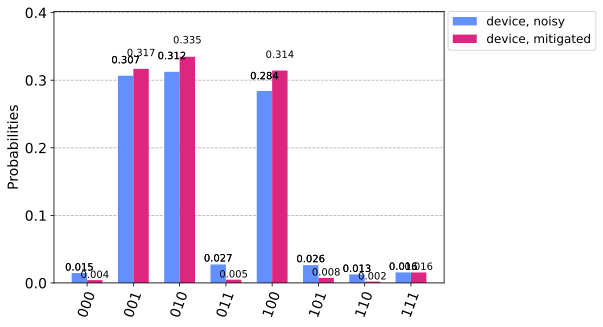

In [37]:
plot_histogram([device_counts_2, mitigated_counts_2], legend=['device, noisy','device, mitigated'])

In [38]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright